# Finance dataの加工

〇手順
1. Nasdaqのデータ（USTEC.pkl）のデータフレームにおいて，1分足から4時間足に変換．
参考：https://kgt-blog.com/python/3466/
2. 各種指標を計算
- pct_change: 変化率
- log_change: 対数変化率
- 20SMA: 単純移動平均線
- 20EMA: 指数平滑移動平均線
- 20ATR: 変動率指標
- 20Upper: ボリンジャーバンド上限
- 20Lower：ボリンジャーバンド下限
3. データフレームに追加し，欠損値Nanを含む列は除外する．
4. データフレームにYearとWeekの系列を追加する．
5. 最終的に，下記のフォーマットのデータフレームにする．（日付はあくまでも例です．）
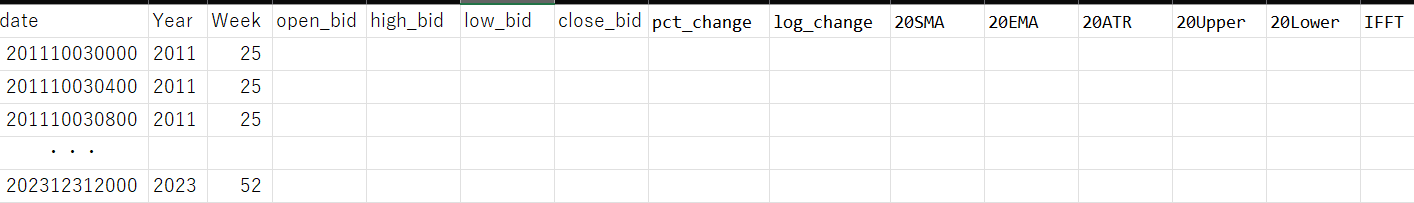

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import pickle

### 中間値の計算

In [2]:
# Pickle file
data = pd.read_pickle('data/stock_data/USTEC.pkl')
data["open_mid"] = (data["open_bid"] + data["open_ask"])/2
data["close_mid"] = (data["close_bid"] + data["close_ask"])/2
data["high_mid"] = (data["high_bid"] + data["high_ask"])/2
data["low_mid"] = (data["low_bid"] + data["low_ask"])/2
# datatime 型のインデックスを作成
data["datetime"] = pd.to_datetime(data["date"], format='%Y%m%d%H%M')

### 4時間足に変換し2017年からのデータに変換

In [3]:
# data を 4時間足に変換
data_4h = data.resample('4H', on='datetime').agg({'open_mid': 'first', 'high_mid': 'max', 'low_mid': 'min', 'close_mid': 'last'})

# 2017年以降のデータを抽出
data_4h = data_4h[data_4h.index >= dt.datetime(2017,1,1)]
data_4h.dropna(inplace=True)


### テクニカル指標の変換

In [4]:
data_4h['pct_change'] = (data_4h['close_mid'] - data_4h['close_mid'].shift(1))/ data_4h['close_mid'].shift(1)
data_4h['log_change'] = np.log(data_4h['close_mid']/ data_4h['close_mid'].shift(1))

In [5]:
from tools import technical_generator
Generator = technical_generator.Generator()

In [6]:
# SMA
data_4h['20SMA'] = Generator.SMA(data_4h['close_mid'], 20)
data_4h['20EMA'] = Generator.EMA(data_4h['close_mid'], 20)
data_4h['20ATR'] = Generator.atr(data_4h['high_mid'], data_4h['low_mid'], 20)
data_4h['20Upper'], data_4h['20Lower'] = Generator.bollinger_band(data_4h['close_mid'], 20)
data_4h.dropna(inplace=True)
data_4h

,open_mid,high_mid,low_mid,close_mid,pct_change,log_change,20SMA,20EMA,20ATR,20Upper,20Lower
datetime,,,,,,,,,,,
2017-01-06 12:00:00,4963.50,4963.65,4960.85,4962.40,-0.000222,-0.000222,4923.8050,4936.761888,15.6925,4973.913933,4873.696067
2017-01-06 16:00:00,4962.40,4963.65,4958.25,4962.25,-0.000030,-0.000030,4927.4800,4939.527388,15.2700,4977.544909,4877.415091
2017-01-06 20:00:00,4962.25,4977.80,4952.85,4977.50,0.003073,0.003068,4931.5900,4943.593543,16.0125,4983.974124,4879.205876
2017-01-07 00:00:00,4977.50,5013.65,4970.65,5010.35,0.006600,0.006578,4937.2925,4950.658241,17.5175,4997.715293,4876.869707
2017-01-07 04:00:00,5010.35,5017.35,5002.15,5003.45,-0.001377,-0.001378,4942.3450,4956.186540,17.1875,5007.218341,4877.471659
...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 12:00:00,14363.20,14365.85,14320.60,14350.70,-0.000870,-0.000871,14332.2925,14391.952249,92.1650,14424.624420,14239.960580
2023-10-31 16:00:00,14350.80,14438.30,14344.40,14425.70,0.005226,0.005213,14338.1350,14395.166321,95.4050,14438.646676,14237.623324
2023-10-31 20:00:00,14425.70,14453.90,14311.90,14417.20,-0.000589,-0.000589,14342.2000,14397.264766,97.0325,14448.727120,14235.672880


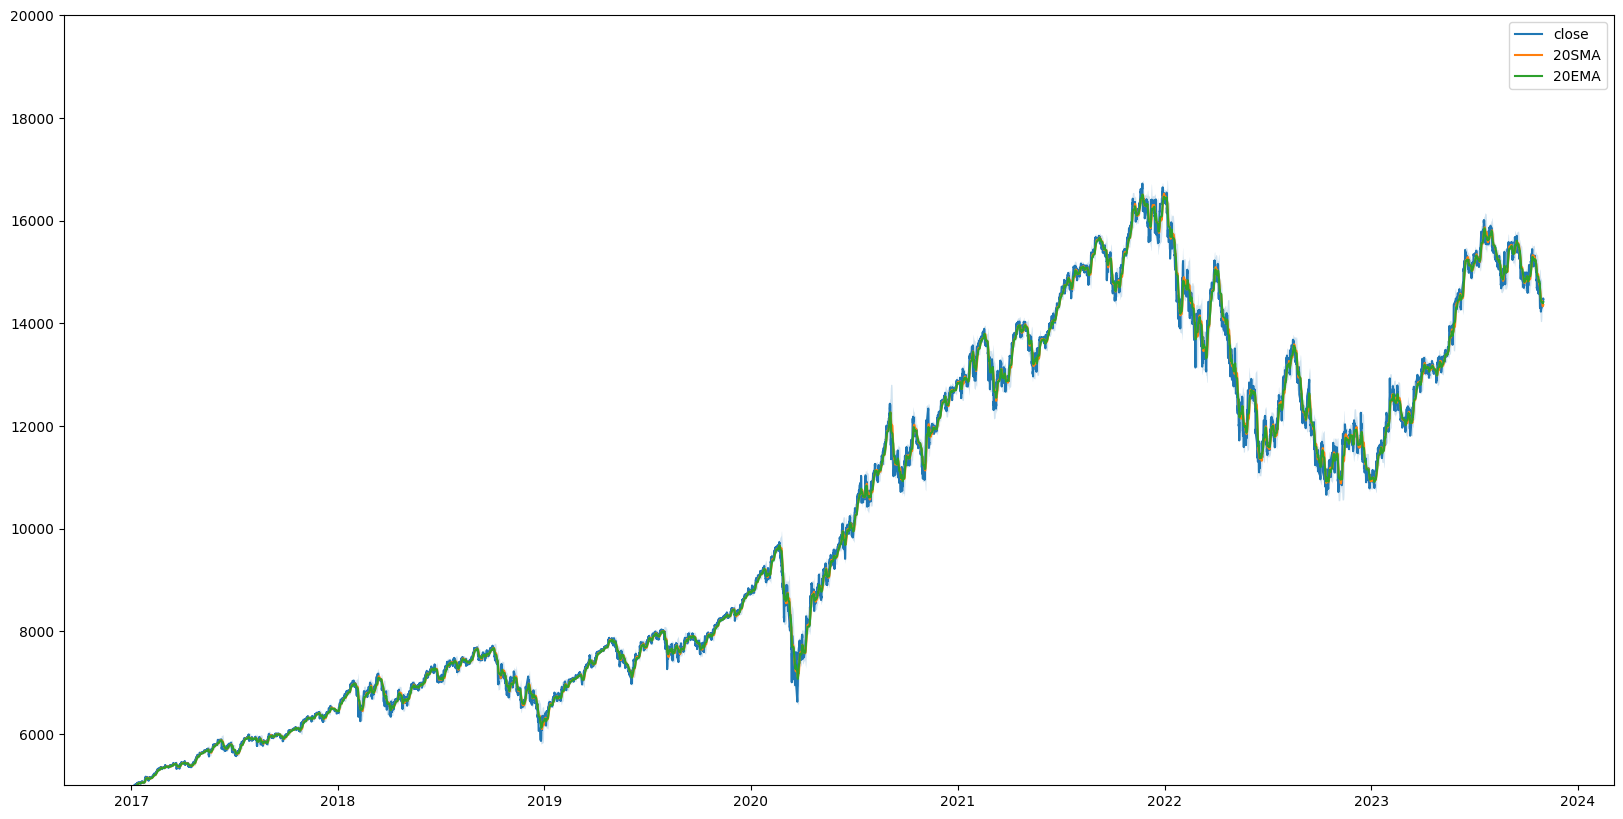

In [7]:
# 可視化（SMA、EMA、ボリンジャーバンド）
plt.figure(figsize=(20,10))
plt.plot(data_4h.index, data_4h['close_mid'], label='close')
plt.plot(data_4h.index, data_4h['20SMA'], label='20SMA')
plt.plot(data_4h.index, data_4h['20EMA'], label='20EMA')
# ボリンジャーバンドを20SMAを中心に2σの範囲で表示。Fillする
plt.fill_between(data_4h.index, data_4h['20Upper'], data_4h['20Lower'], alpha=0.2)
plt.legend()
# 2017~2018年のデータを表示
#plt.xlim(dt.datetime(2018,1,1), dt.datetime(2023,12,31))
plt.ylim(5000, 20000)
plt.show()

### Week&Yearの系列追加

In [8]:
#data_4h["datetime"]の各要素がその年の何周目かを計算。isocalendar()で週番号を取得。weekをdatetimeの右側に追加
from datetime import datetime, timedelta
def week_number_from_first_monday(date):
    year = date.year
    # その年の1月1日の曜日を求める
    first_day_of_year = datetime(year, 1, 1)
    day_of_week = first_day_of_year.weekday()

    # 最初の月曜日を求める
    if day_of_week == 0:  # 1月1日が月曜日の場合
        first_monday = first_day_of_year
    else:  # それ以外の場合、次の月曜日を求める
        first_monday = first_day_of_year + timedelta(days=(7 - day_of_week))

    # 指定された日付までの日数を計算する
    days_since_first_monday = (date - first_monday).days

    # 週番号を計算する（1を加えるのは週番号が1から始まるため）
    week_number = (days_since_first_monday // 7) + 1

    return week_number
data_4h["datetime"] = data_4h.index
data_4h['Week'] = data_4h['datetime'].apply(lambda x: week_number_from_first_monday(x))

# data_4h["datetime"]の各要素が何年かを計算。
data_4h['Year'] = data_4h['datetime'].apply(lambda x: x.year)
# Weekが0の場合は、52に置き換え、Yearを1減らす
data_4h.loc[data_4h['Week']==0, 'Year'] -= 1
data_4h.loc[data_4h['Week']==0, 'Week'] = 52
data_4h

,open_mid,high_mid,low_mid,close_mid,pct_change,log_change,20SMA,20EMA,20ATR,20Upper,20Lower,datetime,Week,Year
datetime,,,,,,,,,,,,,,
2017-01-06 12:00:00,4963.50,4963.65,4960.85,4962.40,-0.000222,-0.000222,4923.8050,4936.761888,15.6925,4973.913933,4873.696067,2017-01-06 12:00:00,1,2017
2017-01-06 16:00:00,4962.40,4963.65,4958.25,4962.25,-0.000030,-0.000030,4927.4800,4939.527388,15.2700,4977.544909,4877.415091,2017-01-06 16:00:00,1,2017
2017-01-06 20:00:00,4962.25,4977.80,4952.85,4977.50,0.003073,0.003068,4931.5900,4943.593543,16.0125,4983.974124,4879.205876,2017-01-06 20:00:00,1,2017
2017-01-07 00:00:00,4977.50,5013.65,4970.65,5010.35,0.006600,0.006578,4937.2925,4950.658241,17.5175,4997.715293,4876.869707,2017-01-07 00:00:00,1,2017
2017-01-07 04:00:00,5010.35,5017.35,5002.15,5003.45,-0.001377,-0.001378,4942.3450,4956.186540,17.1875,5007.218341,4877.471659,2017-01-07 04:00:00,1,2017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 12:00:00,14363.20,14365.85,14320.60,14350.70,-0.000870,-0.000871,14332.2925,14391.952249,92.1650,14424.624420,14239.960580,2023-10-31 12:00:00,44,2023
2023-10-31 16:00:00,14350.80,14438.30,14344.40,14425.70,0.005226,0.005213,14338.1350,14395.166321,95.4050,14438.646676,14237.623324,2023-10-31 16:00:00,44,2023
2023-10-31 20:00:00,14425.70,14453.90,14311.90,14417.20,-0.000589,-0.000589,14342.2000,14397.264766,97.0325,14448.727120,14235.672880,2023-10-31 20:00:00,44,2023


# センチメントデータの格納

In [9]:
import os
import pandas as pd

# カテゴリを市場にマッピング
category_mapping = {
    'US Stock Market': 'US',
    'Japanese Stock Market': 'JP',
    'European Stock Market': 'EU',
    'Chinese Stock Market': 'CH',
    'Global Economic Outlook': 'GE'
}

# 初期化
sentiment_data = pd.DataFrame(columns=['Year', 'Week', 'US', 'JP', 'EU', 'CH', 'GE'])

for year in range(2018, 2024):
    # ファイルを読み込む
    for filename in os.listdir(f'data/text/{year}'):
        
        if filename.endswith('.txt'):
            # ファイル名から情報を抽出
            name_parts = filename.split('_')
            week = name_parts[1]
            category = name_parts[2].replace('.txt', '')

            category = category_mapping.get(category, category)
            filename = f'data/text/{year}/{filename}'
            # ファイルを開く
            with open(filename, 'r', encoding='UTF-16') as file:
                content = file.read().strip()

            # データフレームに追加
            if len(sentiment_data[(sentiment_data['Year'] == year) & (sentiment_data['Week'] == week)]) > 0:
                sentiment_data.loc[(sentiment_data['Year'] == year) & (sentiment_data['Week'] == week), category] = content
            else:
                sentiment_data.loc[len(sentiment_data)] = {'Year': year, 'Week': week, category: content}

# YearとWeekの小さい順に行を並び替え
sentiment_data['Year'] = sentiment_data['Year'].astype(int)
sentiment_data['Week'] = sentiment_data['Week'].astype(int)
sentiment_data = sentiment_data.sort_values(['Year', 'Week'])

# 行のインデックスをリセット
sentiment_data = sentiment_data.reset_index(drop=True)
sentiment_data

,Year,Week,US,JP,EU,CH,GE
0,2018,1,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
1,2018,2,The US stock market sentiment during the secon...,The second week of January 2018 marked a signi...,The European Stock Market during the second we...,The Chinese stock market in the second week of...,"During the second week of January 2018, the gl..."
2,2018,3,The U.S. stock market sentiment during the thi...,"During the third week of January 2018, the Jap...","During the third week of January 2018, the Eur...","During the third week of January 2018, the sen...",The global economic sentiment in the third wee...
3,2018,4,The US stock market sentiment during the fourt...,"During the fourth week of January 2018, the se...",It seems that I am currently experiencing diff...,The Chinese stock market during the fourth wee...,The global economic outlook in the fourth week...
4,2018,5,The sentiment in the US stock market for the w...,"In the fifth week of 2018, spanning from Janua...",The European stock market during the fifth wee...,The Chinese stock market during the week of Ja...,The Global Economic Outlook in the first week ...
...,...,...,...,...,...,...,...
307,2023,48,"The US stock market in the 48th week of 2023, ...","During the 48th week of 2023, the Japanese sto...","During the 48th week of 2023, from November 27...",During the 48th week of 2023 (from November 27...,"As of the 48th week of 2023, the global econom..."
308,2023,49,"During the 49th week of 2023 (December 4-8), t...","In the 49th week of 2023, the Japanese stock m...","In the 49th week of 2023, the European stock m...","During the 49th week of 2023, the sentiment in...",The global economic outlook for the 49th week ...
309,2023,50,The US stock market sentiment during the week ...,The Japanese stock market experienced notable ...,"In the 50th week of 2023, European stock marke...",The Chinese stock market sentiment during the ...,The global economic outlook for the week of De...
310,2023,51,During the 51st week of 2023 (December 18 to D...,The Japanese stock market exhibited strong per...,"During the 51st week of 2023 (December 18-22),...",The Chinese stock market in the 51st week of 2...,The Global Economic Outlook for the 51st week ...


### センチメントデータと結合

In [10]:
# 2018年以降のデータを抽出
data_4h = data_4h[data_4h.index >= dt.datetime(2018,1,1)]
data_4h

,open_mid,high_mid,low_mid,close_mid,pct_change,log_change,20SMA,20EMA,20ATR,20Upper,20Lower,datetime,Week,Year
datetime,,,,,,,,,,,,,,
2018-01-02 08:00:00,6404.55,6423.70,6402.30,6415.50,0.002963,0.002958,6450.1325,6446.834128,15.8450,6487.579983,6412.685017,2018-01-02 08:00:00,1,2018
2018-01-02 12:00:00,6415.50,6423.45,6411.95,6420.70,0.000811,0.000810,6448.1725,6444.345164,15.8800,6487.522555,6408.822445,2018-01-02 12:00:00,1,2018
2018-01-02 16:00:00,6420.70,6421.50,6397.75,6407.90,-0.001994,-0.001996,6445.2325,6440.874196,16.6925,6487.436918,6403.028082,2018-01-02 16:00:00,1,2018
2018-01-02 20:00:00,6407.85,6481.85,6407.75,6481.15,0.011431,0.011366,6446.1750,6444.709987,19.9225,6490.759072,6401.590928,2018-01-02 20:00:00,1,2018
2018-01-03 00:00:00,6480.75,6508.55,6480.15,6507.85,0.004120,0.004111,6448.1200,6450.723321,20.8175,6499.728255,6396.511745,2018-01-03 00:00:00,1,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 12:00:00,14363.20,14365.85,14320.60,14350.70,-0.000870,-0.000871,14332.2925,14391.952249,92.1650,14424.624420,14239.960580,2023-10-31 12:00:00,44,2023
2023-10-31 16:00:00,14350.80,14438.30,14344.40,14425.70,0.005226,0.005213,14338.1350,14395.166321,95.4050,14438.646676,14237.623324,2023-10-31 16:00:00,44,2023
2023-10-31 20:00:00,14425.70,14453.90,14311.90,14417.20,-0.000589,-0.000589,14342.2000,14397.264766,97.0325,14448.727120,14235.672880,2023-10-31 20:00:00,44,2023


In [11]:
# data_4hとsentiment_dataをYearとWeekに関して結合。結合キーはYearとWeek
final_data = pd.merge(data_4h, sentiment_data, on=['Year', 'Week'])
# datetimeをindexに設定
final_data.set_index('datetime', inplace=True)
final_data

,open_mid,high_mid,low_mid,close_mid,pct_change,log_change,20SMA,20EMA,20ATR,20Upper,20Lower,Week,Year,US,JP,EU,CH,GE
datetime,,,,,,,,,,,,,,,,,,
2018-01-02 08:00:00,6404.55,6423.70,6402.30,6415.50,0.002963,0.002958,6450.1325,6446.834128,15.8450,6487.579983,6412.685017,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-02 12:00:00,6415.50,6423.45,6411.95,6420.70,0.000811,0.000810,6448.1725,6444.345164,15.8800,6487.522555,6408.822445,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-02 16:00:00,6420.70,6421.50,6397.75,6407.90,-0.001994,-0.001996,6445.2325,6440.874196,16.6925,6487.436918,6403.028082,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-02 20:00:00,6407.85,6481.85,6407.75,6481.15,0.011431,0.011366,6446.1750,6444.709987,19.9225,6490.759072,6401.590928,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-03 00:00:00,6480.75,6508.55,6480.15,6507.85,0.004120,0.004111,6448.1200,6450.723321,20.8175,6499.728255,6396.511745,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 12:00:00,14363.20,14365.85,14320.60,14350.70,-0.000870,-0.000871,14332.2925,14391.952249,92.1650,14424.624420,14239.960580,44,2023,The US stock market sentiment during the 44th ...,The Japanese stock market exhibited varied sen...,"During the 44th week of 2023, the European sto...","During the 44th week of 2023, Chinese stock ma...",The global economic outlook during the 44th we...
2023-10-31 16:00:00,14350.80,14438.30,14344.40,14425.70,0.005226,0.005213,14338.1350,14395.166321,95.4050,14438.646676,14237.623324,44,2023,The US stock market sentiment during the 44th ...,The Japanese stock market exhibited varied sen...,"During the 44th week of 2023, the European sto...","During the 44th week of 2023, Chinese stock ma...",The global economic outlook during the 44th we...
2023-10-31 20:00:00,14425.70,14453.90,14311.90,14417.20,-0.000589,-0.000589,14342.2000,14397.264766,97.0325,14448.727120,14235.672880,44,2023,The US stock market sentiment during the 44th ...,The Japanese stock market exhibited varied sen...,"During the 44th week of 2023, the European sto...","During the 44th week of 2023, Chinese stock ma...",The global economic outlook during the 44th we...


In [12]:
# weekを52で切り替えずに連番にする。すなわち52週目の次は53週目となる
final_data['Week'] = final_data['Week'] + (final_data['Year'] - 2018) * 52
final_data

,open_mid,high_mid,low_mid,close_mid,pct_change,log_change,20SMA,20EMA,20ATR,20Upper,20Lower,Week,Year,US,JP,EU,CH,GE
datetime,,,,,,,,,,,,,,,,,,
2018-01-02 08:00:00,6404.55,6423.70,6402.30,6415.50,0.002963,0.002958,6450.1325,6446.834128,15.8450,6487.579983,6412.685017,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-02 12:00:00,6415.50,6423.45,6411.95,6420.70,0.000811,0.000810,6448.1725,6444.345164,15.8800,6487.522555,6408.822445,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-02 16:00:00,6420.70,6421.50,6397.75,6407.90,-0.001994,-0.001996,6445.2325,6440.874196,16.6925,6487.436918,6403.028082,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-02 20:00:00,6407.85,6481.85,6407.75,6481.15,0.011431,0.011366,6446.1750,6444.709987,19.9225,6490.759072,6401.590928,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
2018-01-03 00:00:00,6480.75,6508.55,6480.15,6507.85,0.004120,0.004111,6448.1200,6450.723321,20.8175,6499.728255,6396.511745,1,2018,"In the first week of January 2018, the US stoc...","During the first week of 2018, the Japanese st...",It seems I'm currently experiencing technical ...,"In the first week of 2018, the sentiment in th...","During the first week of January 2018, the glo..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 12:00:00,14363.20,14365.85,14320.60,14350.70,-0.000870,-0.000871,14332.2925,14391.952249,92.1650,14424.624420,14239.960580,304,2023,The US stock market sentiment during the 44th ...,The Japanese stock market exhibited varied sen...,"During the 44th week of 2023, the European sto...","During the 44th week of 2023, Chinese stock ma...",The global economic outlook during the 44th we...
2023-10-31 16:00:00,14350.80,14438.30,14344.40,14425.70,0.005226,0.005213,14338.1350,14395.166321,95.4050,14438.646676,14237.623324,304,2023,The US stock market sentiment during the 44th ...,The Japanese stock market exhibited varied sen...,"During the 44th week of 2023, the European sto...","During the 44th week of 2023, Chinese stock ma...",The global economic outlook during the 44th we...
2023-10-31 20:00:00,14425.70,14453.90,14311.90,14417.20,-0.000589,-0.000589,14342.2000,14397.264766,97.0325,14448.727120,14235.672880,304,2023,The US stock market sentiment during the 44th ...,The Japanese stock market exhibited varied sen...,"During the 44th week of 2023, the European sto...","During the 44th week of 2023, Chinese stock ma...",The global economic outlook during the 44th we...


In [13]:
# Export
final_data.to_pickle('data/sentiment_stock_data.pkl')

(0.0, 50.0)

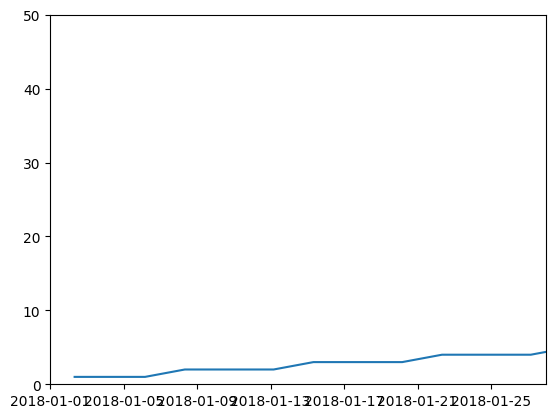

In [22]:
plt.plot(final_data["Week"])
plt.xlim(dt.datetime(2018,1,1), dt.datetime(2018,1,28))
plt.ylim(0, 50)